### Telcom Customer Churn Analysis
Churner is generally defined as a customer who stops using a product or service for a given period of time.
This notebook is to do the data analysis and predictions on the telecom-data.csv file.
The first step in the Data Preprocessing is to import the libraries, load the data and do some Exploratory Data Analysis (EDA).


Importing the Libraries 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from math import * # module math
import matplotlib.pyplot as plt # visualization
from PIL import Image
import seaborn as sns # visualization
import itertools
import io
import plotly.offline as py # visualization
py.init_notebook_mode(connected=True) # visualization
import plotly.graph_objs as go # visualization
from plotly.subplots import make_subplots
import plotly.figure_factory as ff # visualization
import warnings
warnings.filterwarnings("ignore")
import os
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier as GBSklearn
from xgboost import XGBClassifier as XGB
import lightgbm as lgb


In [2]:
telcom = pd.read_csv("telecom-data.csv")

telcom.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Function to overview the data 


In [3]:
def dataoveriew(df, message):
    print(f'{message}:\n')
    print("Rows:", df.shape[0])
    print("\nNumber of features:", df.shape[1])
    print("\nFeatures:")
    print(telcom.columns.tolist())
    print("\nMissing values:", df.isnull().sum().values.sum())
    print("\nUnique values:")
    print(df.nunique())

In [4]:
dataoveriew(telcom, 'Overiew of the training dataset')


Overiew of the training dataset:

Rows: 7043

Number of features: 21

Features:
['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Missing values: 0

Unique values:
customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64


Explolatory Data Analysis

In [5]:
#Counting the number of Male and Females 
gender_count = telcom['gender'].value_counts()
gender_pct= gender_count / len(telcom.index)

gender = pd.concat([gender_count, round(gender_pct,2)], axis=1)\
        .set_axis(['count', 'pct'], axis=1, inplace=False)
gender

,count,pct
Male,3555,0.5
Female,3488,0.5


Now, let's just check the relationship between the features and the outcome ('Churn').

In [6]:
def count_by_group(data, feature, target):
    df = data.groupby([feature, target])[target].agg(['count'])
    temp = data.groupby([feature])[target].agg(['count'])
    df['pct'] = 100*df.div(temp, level = feature).reset_index()['count'].values
    return df.reset_index()

In [7]:
count_by_group(telcom, feature = 'gender', target = 'Churn')

,gender,Churn,count,pct
0,Female,No,2549,73.079128
1,Female,Yes,939,26.920872
2,Male,No,2625,73.839662
3,Male,Yes,930,26.160338


In [8]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

In [9]:
from plotly.offline import init_notebook_mode, iplot
configure_plotly_browser_state()
init_notebook_mode(connected=False)

trace = go.Pie(labels = telcom["Churn"].value_counts().keys().tolist(),
               values = telcom["Churn"].value_counts().values.tolist(),
               marker = dict(colors = ['royalblue','lime'],
                             line = dict(color = "white", width =  1.3)
                            ),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = .5
              )
layout = go.Layout(dict(title = "Customer churn in data",
                        plot_bgcolor = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )
data = [trace]
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

Output hidden; open in https://colab.research.google.com to view.

## .Variable distributions

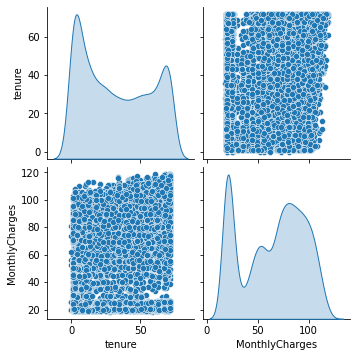

In [10]:
#Separating columns to be visualized
out_cols = list(set(telcom.nunique()[telcom.nunique()<6].keys().tolist()
                    + telcom.select_dtypes(include='object').columns.tolist()))
viz_cols = [x for x in telcom.columns if x not in out_cols] + ['Churn']

sns.pairplot(telcom[viz_cols], diag_kind="kde")
plt.show()

Several of the numerical data are very correlated. (Total day minutes and Total day charge), (Total eve minutes and Total eve charge), (Total night minutes and Total night charge) and lastly (Total intl minutes and Total intl charge) are alo correlated. We only have to select one of them.



### . Predictive Models
Separating Dataset into X and y subsets¶
In this project we will test the following models and choose the best one based on the accuracy, balanced accuracy, and Churn Recall.
Models to be tested:
Logistic Regression (Package: Sklearn)
Naive Bayes Classifier
Random Forest (SKlearn)
Multi Layers Perceptron - MLP (Package: Sklearn)
XGBoost (Package: XGBoost)
XGB: Gradient Boosting Classifier (Package: Sklearn)
Light GBM (Package: LightGBM)
As we have imbalanced dataset, we will test all the models defined above using two different strategies:
Complete training set (80% of the dataset)
Balanced training set, where we randomly select from the complete tranning set the same number of Stayed and Exited customers.

 ### One-Hot encoding Categorical Attributes

In [11]:
#Removing correlated and unneccessary columns
col_to_drop = ['customerID','tenure','MonthlyCharges','TotalCharges']
telcom = telcom.drop(columns = col_to_drop, axis = 1)


In [12]:
# One-Hot encoding our categorical attributes
list_cat = ['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity',       
'OnlineBackup','DeviceProtection', 'TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod' ]         
telcom = pd.get_dummies(telcom, columns = list_cat, prefix = list_cat)
telcom.head()

,Churn,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,No,1,0,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
1,No,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1
2,Yes,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
3,No,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0
4,Yes,1,0,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0


In [13]:
dataoveriew(telcom, 'number of columns after one hot encoding')

number of columns after one hot encoding:

Rows: 7043

Number of features: 44

Features:
['Churn', 'gender_Female', 'gender_Male', 'SeniorCitizen_0', 'SeniorCitizen_1', 'Partner_No', 'Partner_Yes', 'Dependents_No', 'Dependents_Yes', 'PhoneService_No', 'PhoneService_Yes', 'MultipleLines_No', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_No', 'PaperlessBill

In [14]:
X = telcom.iloc[:, 1:43]
y = telcom.loc[:, 'Churn']

In [15]:
features = list(X)

In [16]:
features

['gender_Female',
 'gender_Male',
 'SeniorCitizen_0',
 'SeniorCitizen_1',
 'Partner_No',
 'Partner_Yes',
 'Dependents_No',
 'Dependents_Yes',
 'PhoneService_No',
 'PhoneService_Yes',
 'MultipleLines_No',
 'MultipleLines_No phone service',
 'MultipleLines_Yes',
 'InternetService_DSL',
 'InternetService_Fiber optic',
 'InternetService_No',
 'OnlineSecurity_No',
 'OnlineSecurity_No internet service',
 'OnlineSecurity_Yes',
 'OnlineBackup_No',
 'OnlineBackup_No internet service',
 'OnlineBackup_Yes',
 'DeviceProtection_No',
 'DeviceProtection_No internet service',
 'DeviceProtection_Yes',
 'TechSupport_No',
 'TechSupport_No internet service',
 'TechSupport_Yes',
 'StreamingTV_No',
 'StreamingTV_No internet service',
 'StreamingTV_Yes',
 'StreamingMovies_No',
 'StreamingMovies_No internet service',
 'StreamingMovies_Yes',
 'Contract_Month-to-month',
 'Contract_One year',
 'Contract_Two year',
 'PaperlessBilling_No',
 'PaperlessBilling_Yes',
 'PaymentMethod_Bank transfer (automatic)',
 'Paym

In [17]:
X.shape

(7043, 42)

In [18]:
y.shape

(7043,)


## 2.2 Splitting the dataset into the Training set and Test set
Now, let's split the data intro train and test sets (80% and 20%, respectively).

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

### Since we do have a large amount of columns to train with, we can apply Principal Component Analysis to select columns that will have a good effect on our model and predicitions

In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 36)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

Function to plot the Confusion Matrix

In [21]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### Complete Trainning Set
 Logistic Regression (Sklearn)
For the first prediction, let's use the Sklearn Logistic Regression searching for the best parameters using the GridSearchCV function:

In [22]:
parameters = {'C': [0.01, 0.1, 1, 10],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'max_iter': [50, 100, 150]}
LR = LogisticRegression(penalty = 'l2')
model_LR = GridSearchCV(LR, parameters, cv = 5, n_jobs = 10, verbose = 1).fit(X_train, y_train)
pd.DataFrame(model_LR.cv_results_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    4.5s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    9.4s
[Parallel(n_jobs=10)]: Done 300 out of 300 | elapsed:   13.2s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.191843,0.038725,0.011883,0.007237,0.01,50,newton-cg,"{'C': 0.01, 'max_iter': 50, 'solver': 'newton-...",0.792810,0.777673,0.792614,0.765152,0.801136,0.785877,0.012831,49
1,0.122628,0.003823,0.012191,0.006094,0.01,50,lbfgs,"{'C': 0.01, 'max_iter': 50, 'solver': 'lbfgs'}",0.792810,0.777673,0.792614,0.765152,0.801136,0.785877,0.012831,49
2,0.129015,0.013106,0.011637,0.006279,0.01,50,liblinear,"{'C': 0.01, 'max_iter': 50, 'solver': 'libline...",0.790918,0.789026,0.792614,0.770833,0.806818,0.790042,0.011479,1
3,0.197234,0.022773,0.017630,0.003002,0.01,50,sag,"{'C': 0.01, 'max_iter': 50, 'solver': 'sag'}",0.792810,0.777673,0.792614,0.765152,0.801136,0.785877,0.012831,49
4,0.312384,0.008289,0.012996,0.009467,0.01,50,saga,"{'C': 0.01, 'max_iter': 50, 'solver': 'saga'}",0.792810,0.777673,0.792614,0.765152,0.801136,0.785877,0.012831,49
5,0.237104,0.029605,0.013530,0.009915,0.01,100,newton-cg,"{'C': 0.01, 'max_iter': 100, 'solver': 'newton...",0.792810,0.777673,0.792614,0.765152,0.801136,0.785877,0.012831,49
6,0.110187,0.018189,0.010657,0.003232,0.01,100,lbfgs,"{'C': 0.01, 'max_iter': 100, 'solver': 'lbfgs'}",0.792810,0.777673,0.792614,0.765152,0.801136,0.785877,0.012831,49
7,0.125462,0.011300,0.016060,0.001666,0.01,100,liblinear,"{'C': 0.01, 'max_iter': 100, 'solver': 'liblin...",0.790918,0.789026,0.792614,0.770833,0.806818,0.790042,0.011479,1
8,0.232387,0.011074,0.016576,0.007164,0.01,100,sag,"{'C': 0.01, 'max_iter': 100, 'solver': 'sag'}",0.792810,0.777673,0.792614,0.765152,0.801136,0.785877,0.012831,49
9,0.321223,0.016483,0.012328,0.006400,0.01,100,saga,"{'C': 0.01, 'max_iter': 100, 'solver': 'saga'}",0.792810,0.777673,0.792614,0.765152,0.801136,0.785877,0.012831,49


In [23]:
print(model_LR.best_params_)

{'C': 0.01, 'max_iter': 50, 'solver': 'liblinear'}


Now that we know the "best" parameters for the model, let's do a Recursive Feature Elimination to check the feature importance.

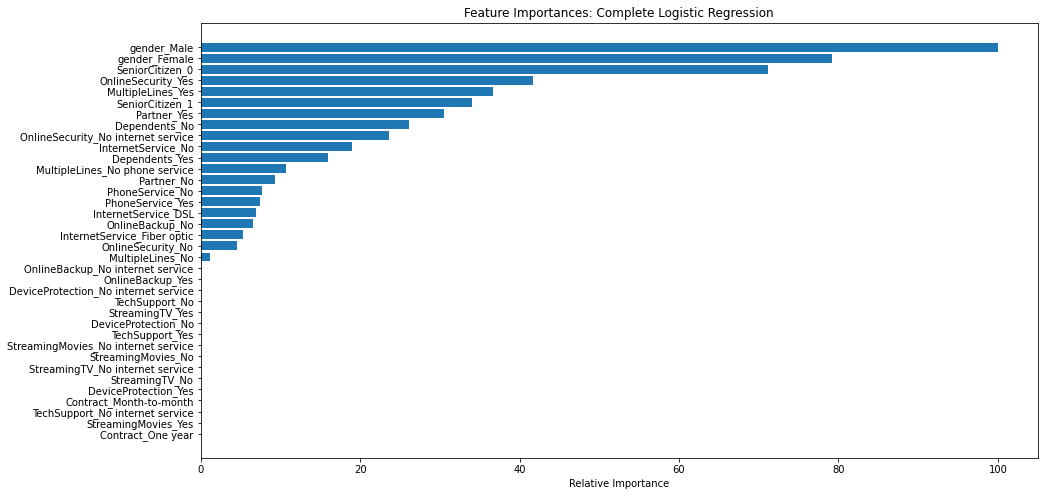

In [24]:
model = LogisticRegression(**model_LR.best_params_)
model.fit(X_train, y_train)

importances = abs(model.coef_[0])
importances = 100.0 * (importances / importances.max())
indices = np.argsort(importances)

plt.figure(figsize = (15, 8))
plt.title('Feature Importances: Complete Logistic Regression')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Now, let's compute the predictions for the best set of parameters:


In [25]:
pred = model_LR.predict(X_test)
predp = model_LR.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, pred)



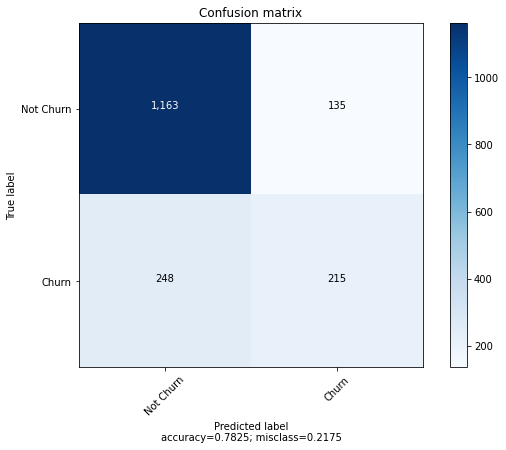

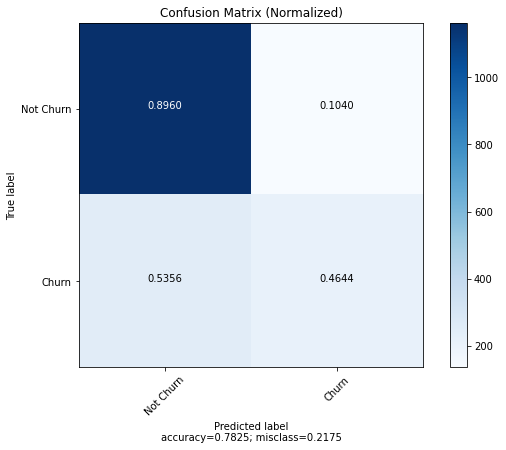

In [26]:
plot_confusion_matrix(cm, target_names = ['Not Churn', 'Churn'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Churn', 'Churn'], normalize = True, title = 'Confusion Matrix (Normalized)')


### MLP: Multi Layers Perceptron
Now, let's enter in the Neural Networks domain, by doing predictions using the Sklear Multi-Layer Perceptron (MLP) Classifier.


In [27]:
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)

In [28]:
predMLP= clf.predict(X_test)
predpMLP = clf.predict_proba(X_test)[:,1]
cmMLP = confusion_matrix(y_test, predMLP)


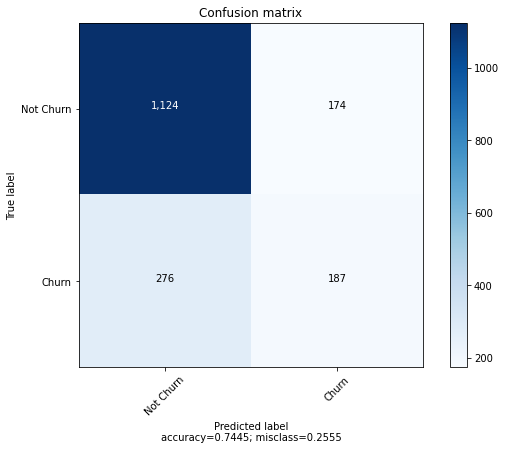

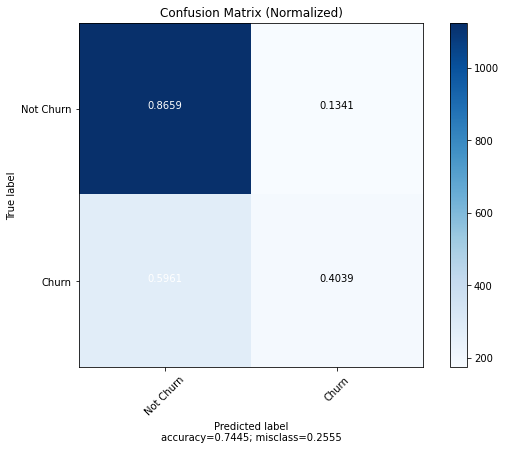

In [29]:
plot_confusion_matrix(cmMLP, target_names = ['Not Churn', 'Churn'], normalize = False)
plot_confusion_matrix(cmMLP, target_names = ['Not Churn', 'Churn'], normalize = True, title = 'Confusion Matrix (Normalized)')


K Nearest Neigbors Classifier

In [30]:
from sklearn.neighbors import KNeighborsClassifier
clfKN = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
clfKN.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [31]:
predKNN= clfKN.predict(X_test)
predpKNN = clfKN.predict_proba(X_test)[:,1]
cmKNN = confusion_matrix(y_test, predKNN)

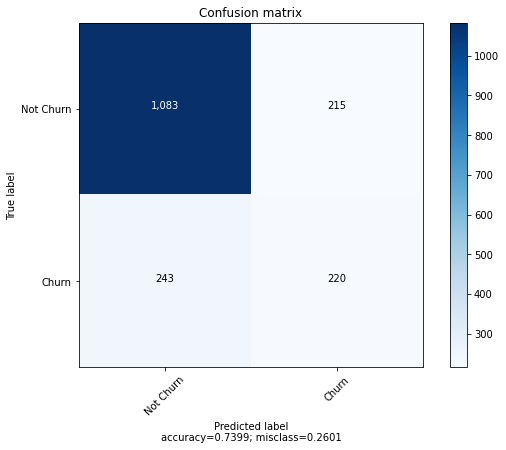

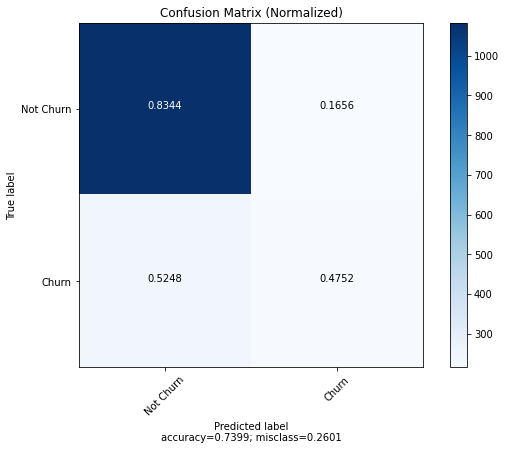

In [32]:
plot_confusion_matrix(cmKNN, target_names = ['Not Churn', 'Churn'], normalize = False)
plot_confusion_matrix(cmKNN, target_names = ['Not Churn', 'Churn'], normalize = True, title = 'Confusion Matrix (Normalized)')


### SVM Classifier

In [33]:
from sklearn.svm import SVC
clfSVM = SVC(kernel = 'linear', random_state = 0)
clfSVM.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [34]:
predSVM= clfSVM.predict(X_test)
cmSVM = confusion_matrix(y_test, predSVM)

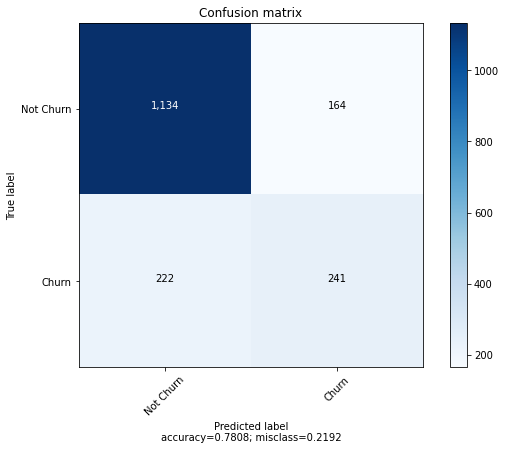

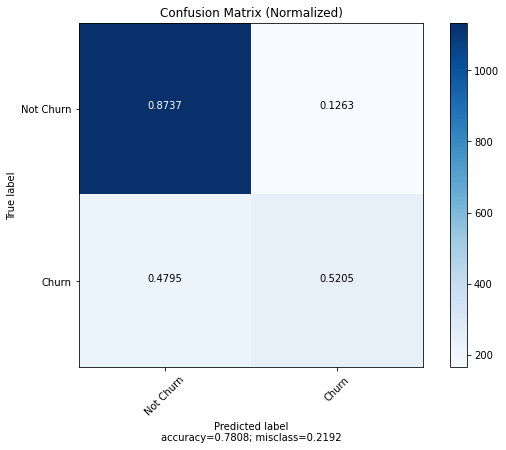

In [35]:
plot_confusion_matrix(cmSVM, target_names = ['Not Churn', 'Churn'], normalize = False)
plot_confusion_matrix(cmSVM, target_names = ['Not Churn', 'Churn'], normalize = True, title = 'Confusion Matrix (Normalized)')


###  Gradient Boosting Classifier (Sklearn)
Now, let's use the Sklearn Gradient Boosting Classifier algorithm for the predictions.

In [36]:
parameters = {'max_depth': [2, 3, 4, 6, 10, 15],
              'n_estimators': [50, 100, 300, 500]}
GB = GBSklearn()
model_GB = GridSearchCV(GB, parameters, cv = 5, n_jobs = 10, verbose = 1).fit(X_train, y_train)
pd.DataFrame(model_GB.cv_results_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.5min
[Parallel(n_jobs=10)]: Done 120 out of 120 | elapsed: 16.7min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.803264,0.241005,0.014491,0.005845,2,50,"{'max_depth': 2, 'n_estimators': 50}",0.788079,0.783349,0.791667,0.760417,0.787879,0.782278,0.011245,4
1,14.176323,0.080726,0.021564,0.005712,2,100,"{'max_depth': 2, 'n_estimators': 100}",0.789972,0.788079,0.800189,0.754735,0.792614,0.785118,0.015740,1
2,42.799015,0.189389,0.035557,0.009667,2,300,"{'max_depth': 2, 'n_estimators': 300}",0.782403,0.773888,0.787879,0.757576,0.795455,0.779440,0.013002,5
3,71.281040,0.363847,0.054194,0.004224,2,500,"{'max_depth': 2, 'n_estimators': 500}",0.777673,0.771050,0.774621,0.743371,0.797348,0.772813,0.017314,8
4,9.506670,0.038356,0.019444,0.004675,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.790918,0.781457,0.794508,0.762311,0.784091,0.782657,0.011191,3
5,19.212768,0.107031,0.029325,0.006514,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.782403,0.777673,0.790720,0.757576,0.782197,0.778114,0.011099,6
6,57.888075,0.153277,0.048097,0.003470,3,300,"{'max_depth': 3, 'n_estimators': 300}",0.776727,0.753075,0.774621,0.756629,0.781250,0.768460,0.011372,10
7,96.330668,0.378251,0.063011,0.006396,3,500,"{'max_depth': 3, 'n_estimators': 500}",0.757805,0.750237,0.768939,0.746212,0.776515,0.759942,0.011339,12
8,11.965404,0.072263,0.027265,0.005616,4,50,"{'max_depth': 4, 'n_estimators': 50}",0.781457,0.781457,0.795455,0.758523,0.796402,0.782659,0.013697,2
9,24.075494,0.051395,0.024934,0.005898,4,100,"{'max_depth': 4, 'n_estimators': 100}",0.771996,0.775781,0.784091,0.762311,0.785985,0.776033,0.008586,7


In [37]:
print(model_GB.best_params_)

{'max_depth': 2, 'n_estimators': 100}


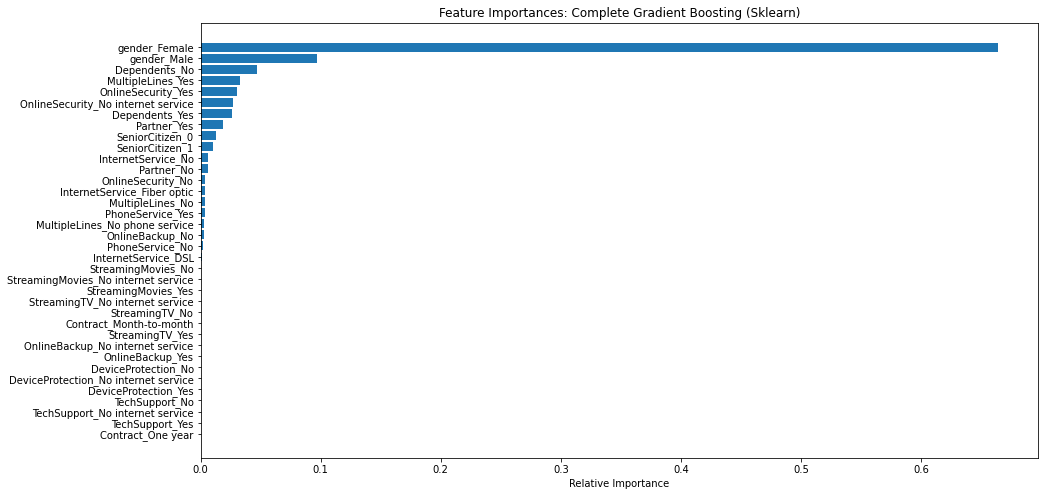

In [38]:
modelGB = GBSklearn(**model_GB.best_params_)
modelGB.fit(X_train, y_train)

importances = modelGB.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize = (15, 8))
plt.title('Feature Importances: Complete Gradient Boosting (Sklearn)')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


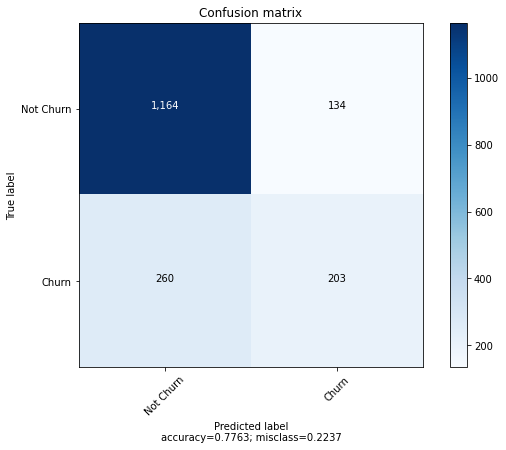

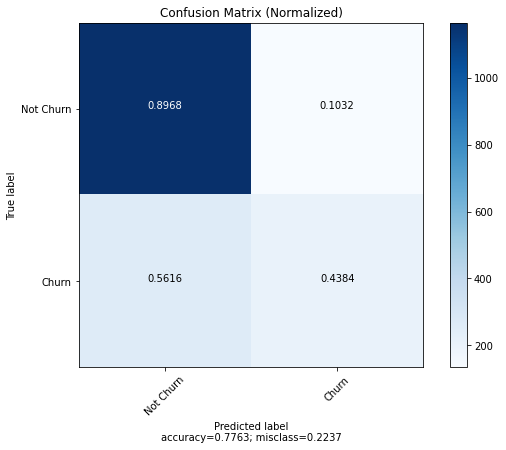

In [56]:
predGB= modelGB.predict(X_test)
predpGB = modelGB.predict_proba(X_test)[:,1]

cmGB = confusion_matrix(y_test, predGB)
plot_confusion_matrix(cmGB, target_names = ['Not Churn', 'Churn'], normalize = False)
plot_confusion_matrix(cmGB, target_names = ['Not Churn', 'Churn'], normalize = True, title = 'Confusion Matrix (Normalized)')



###  Extreme Gradient Boosting (XGBoost)
Let's get out of the Scikit-learn for now and try the package XGBoost

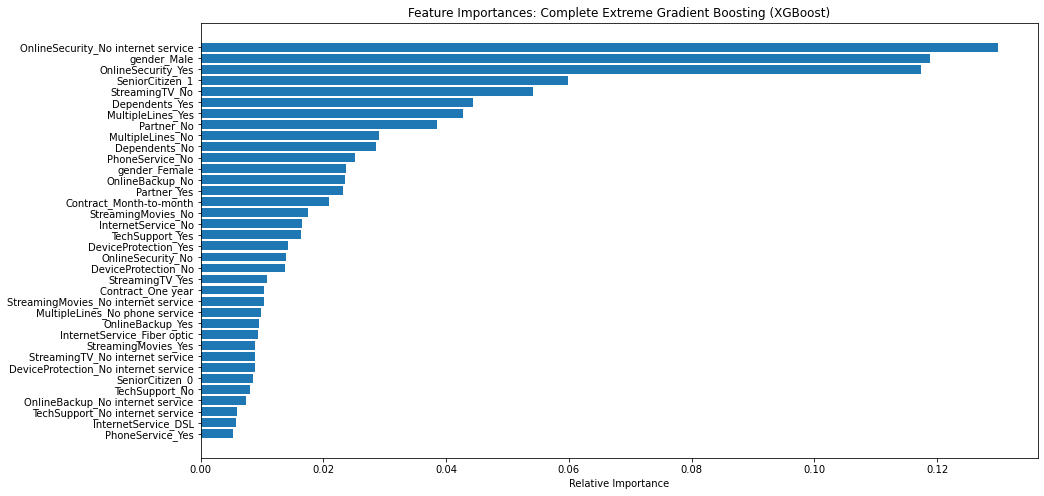

In [40]:
model_XGB = XGB(max_depth = 6,
            learning_rate = .1,
            n_estimators = 100,
            reg_lambda = 0.5,
            reg_alpha = 0,
            verbosity = 1,
            n_jobs = -1,
            tree_method = 'gpu_exact').fit(X_train, y_train)

pred_XGB = model_XGB.predict(X_test)
predp_XGB = model_XGB.predict_proba(X_test)[:,1]

importances = model_XGB.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize = (15, 8))
plt.title('Feature Importances: Complete Extreme Gradient Boosting (XGBoost)')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

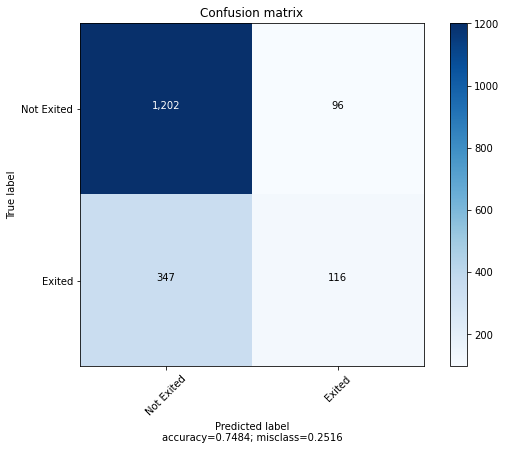

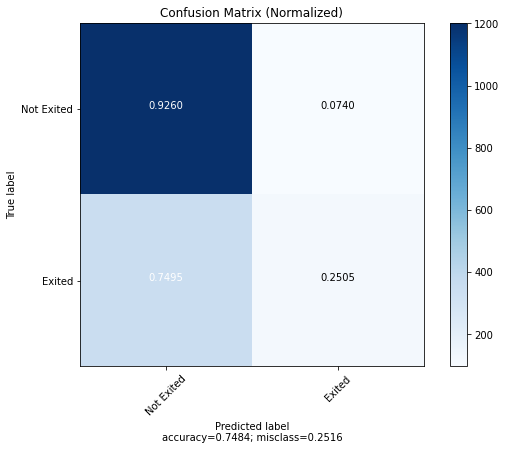

In [41]:
cm_XGB = confusion_matrix(y_test, pred_XGB)
plot_confusion_matrix(cm_XGB, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm_XGB, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')


### NAIVE BAYES CLASSIFIER

In [42]:
from sklearn.naive_bayes import GaussianNB
clf_NB = GaussianNB()
clf_NB.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [46]:
pred_NB = clf_NB.predict(X_test)
predp_NB= clf_NB.predict_proba(X_test)[:,1]

In [47]:
from sklearn.inspection import permutation_importance

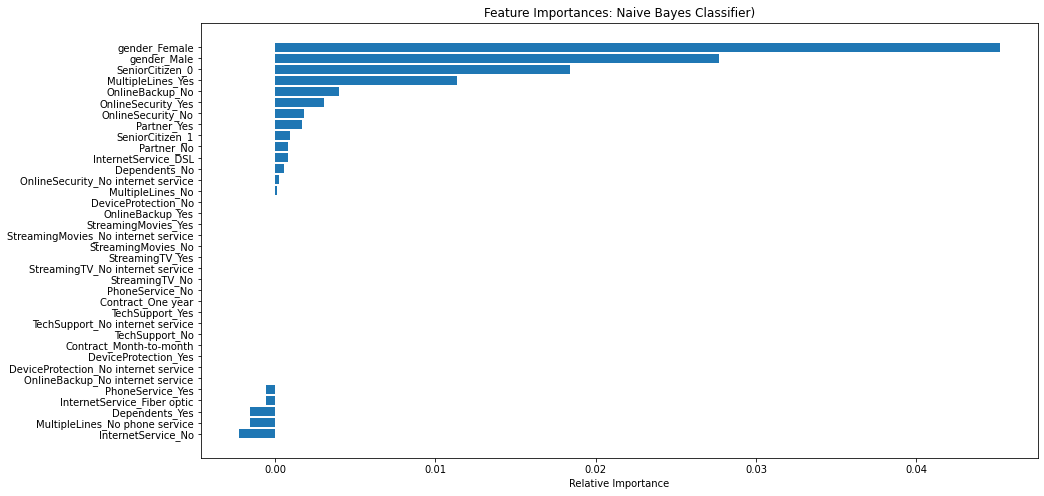

In [48]:
imps = permutation_importance(clf_NB, X_test, y_test)
importances = imps.importances_mean
std = imps.importances_std
indices = np.argsort(importances)

plt.figure(figsize = (15, 8))
plt.title('Feature Importances: Naive Bayes Classifier)')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

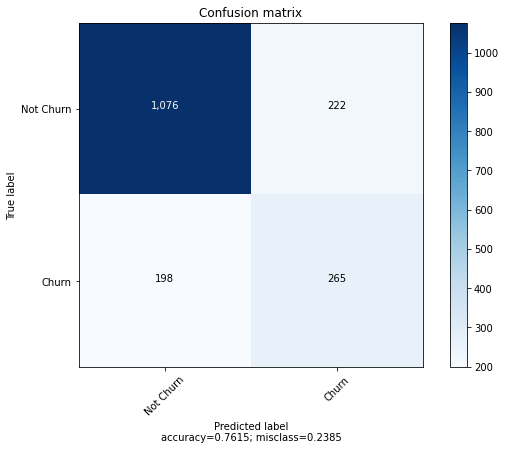

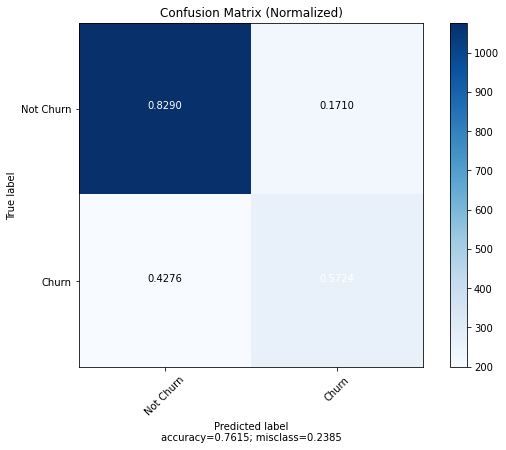

In [57]:
cm_NB = confusion_matrix(y_test, pred_NB)
plot_confusion_matrix(cm_NB, target_names = ['Not Churn', 'Churn'], normalize = False)
plot_confusion_matrix(cm_NB, target_names = ['Not Churn', 'Churn'], normalize = True, title = 'Confusion Matrix (Normalized)')

In [51]:
from sklearn.tree import DecisionTreeClassifier
clf_DTC = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
clf_DTC.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [52]:
pred_DTC = clf_DTC.predict(X_test)
predp_DTC= clf_DTC.predict_proba(X_test)[:,1]

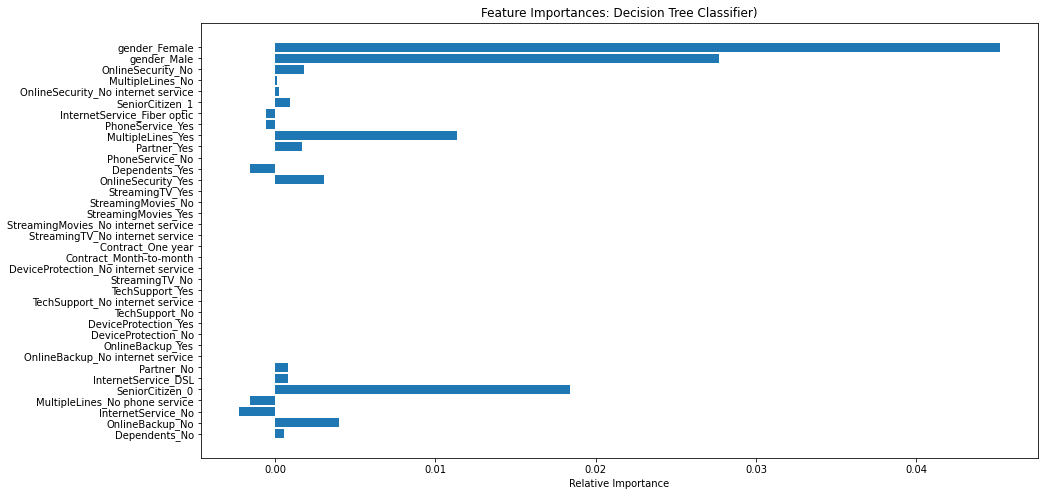

In [54]:
imps_DTC = permutation_importance(clf_DTC, X_test, y_test)
importances_DTC = imps_DTC.importances_mean
std_DTC = imps_DTC.importances_std
indices = np.argsort(importances_DTC)

plt.figure(figsize = (15, 8))
plt.title('Feature Importances: Decision Tree Classifier)')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

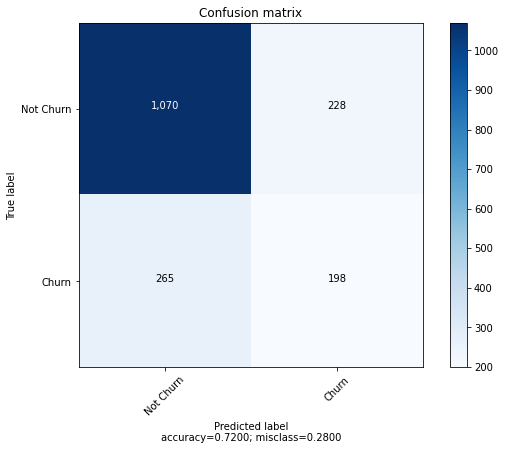

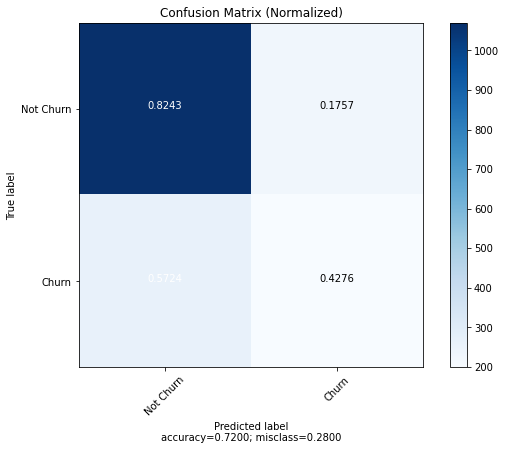

In [55]:
cm_DTC = confusion_matrix(y_test, pred_DTC)
plot_confusion_matrix(cm_DTC, target_names = ['Not Churn', 'Churn'], normalize = False)
plot_confusion_matrix(cm_DTC, target_names = ['Not Churn', 'Churn'], normalize = True, title = 'Confusion Matrix (Normalized)')